<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Hourly Time Series Forecasting using XGBoost



# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Load the dataset
<hr style="border:2px solid black"> </hr>


- The data we will be using is hourly power consumption data from PJM



In [2]:
pjme = pd.read_csv('./PJME_hourly.csv', index_col=[0], parse_dates=[0])

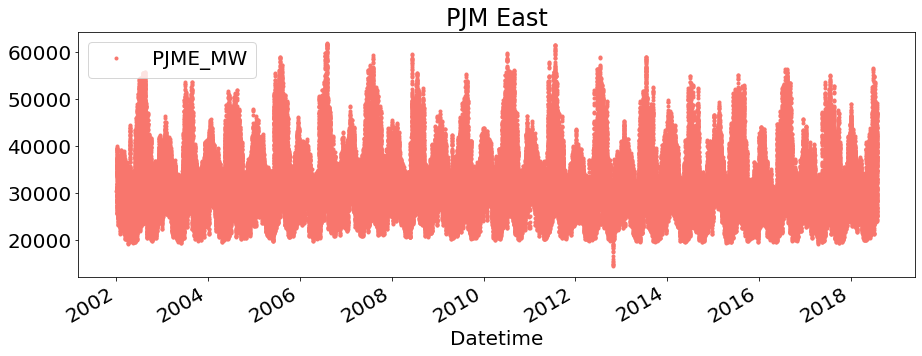

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38",
             "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJM East')

# Split the data


- Cut off the data after 2015 to use as our validation set.



In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

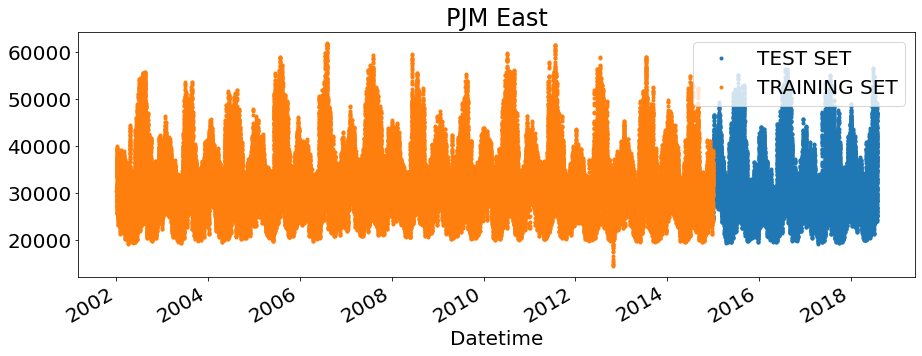

In [5]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create time series features

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear deprecated!
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
        
    
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# We have to change the type otherwise XGBoost will complain
X_train = X_train.astype("float")
X_test = X_test.astype("float")

In [8]:
X_train["weekofyear"].unique()

array([ 1., 52., 51., 50., 49., 48., 47., 46., 45., 44., 43., 42., 41.,
       40., 39., 38., 37., 36., 35., 34., 33., 32., 31., 30., 29., 28.,
       27., 26., 25., 24., 23., 22., 21., 20., 19., 18., 17., 16., 15.,
       14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,
       53.])

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113927 entries, 2002-12-31 01:00:00 to 2014-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hour        113927 non-null  float64
 1   dayofweek   113927 non-null  float64
 2   quarter     113927 non-null  float64
 3   month       113927 non-null  float64
 4   year        113927 non-null  float64
 5   dayofyear   113927 non-null  float64
 6   dayofmonth  113927 non-null  float64
 7   weekofyear  113927 non-null  float64
dtypes: float64(8)
memory usage: 11.9 MB


In [34]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1.0,1.0,4.0,12.0,2002.0,365.0,31.0,1.0
2002-12-31 02:00:00,2.0,1.0,4.0,12.0,2002.0,365.0,31.0,1.0
2002-12-31 03:00:00,3.0,1.0,4.0,12.0,2002.0,365.0,31.0,1.0
2002-12-31 04:00:00,4.0,1.0,4.0,12.0,2002.0,365.0,31.0,1.0
2002-12-31 05:00:00,5.0,1.0,4.0,12.0,2002.0,365.0,31.0,1.0
...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,20.0,2.0,1.0,1.0,2014.0,1.0,1.0,1.0
2014-01-01 21:00:00,21.0,2.0,1.0,1.0,2014.0,1.0,1.0,1.0
2014-01-01 22:00:00,22.0,2.0,1.0,1.0,2014.0,1.0,1.0,1.0


# Create XGBoost model

In [10]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
       verbose = True)

[0]	validation_0-rmse:23192.06200	validation_1-rmse:22274.66915
[1]	validation_0-rmse:16422.15718	validation_1-rmse:15525.66755
[2]	validation_0-rmse:11739.36722	validation_1-rmse:10989.66258
[3]	validation_0-rmse:8542.61317	validation_1-rmse:7892.59073
[4]	validation_0-rmse:6395.35741	validation_1-rmse:5904.56685
[5]	validation_0-rmse:4993.31587	validation_1-rmse:4822.39960


/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:4106.51334	validation_1-rmse:4249.08648
[7]	validation_0-rmse:3587.12672	validation_1-rmse:3946.07875
[8]	validation_0-rmse:3263.06197	validation_1-rmse:3822.64968
[9]	validation_0-rmse:3082.68153	validation_1-rmse:3769.57273
[10]	validation_0-rmse:2983.51794	validation_1-rmse:3736.43056
[11]	validation_0-rmse:2867.11332	validation_1-rmse:3753.34077
[12]	validation_0-rmse:2788.34947	validation_1-rmse:3792.44857
[13]	validation_0-rmse:2749.21369	validation_1-rmse:3830.48390
[14]	validation_0-rmse:2675.58311	validation_1-rmse:3839.60104
[15]	validation_0-rmse:2653.06963	validation_1-rmse:3845.69257
[16]	validation_0-rmse:2583.63422	validation_1-rmse:3884.04111
[17]	validation_0-rmse:2567.66433	validation_1-rmse:3894.41795
[18]	validation_0-rmse:2538.37580	validation_1-rmse:3902.42057
[19]	validation_0-rmse:2526.38114	validation_1-rmse:3900.85811
[20]	validation_0-rmse:2519.88514	validation_1-rmse:3902.71078
[21]	validation_0-rmse:2495.46076	validation_1-rmse:3909.45

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
results = reg.evals_result()

In [12]:
range(len(results['validation_0']["rmse"]))

range(0, 61)

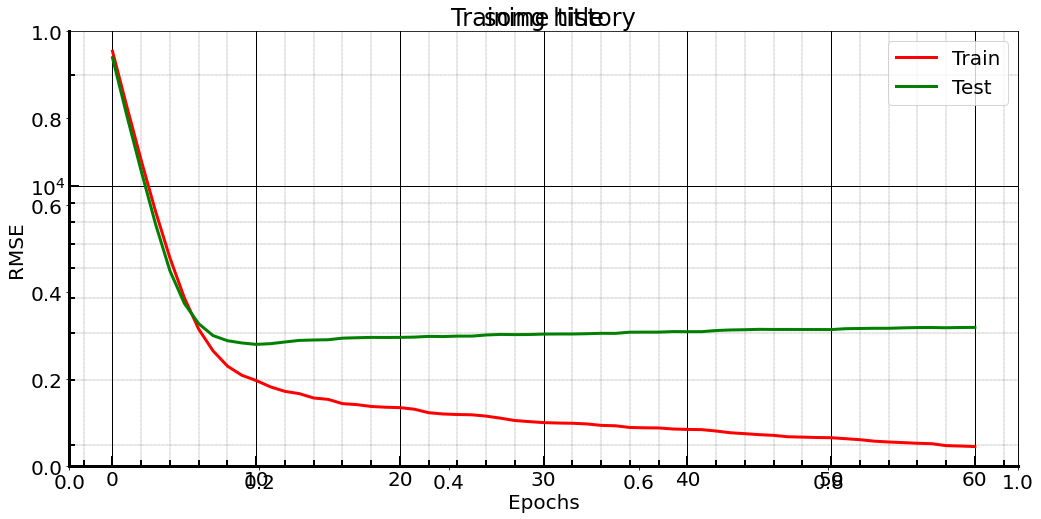

In [13]:
fig = plt.figure() 

plt.title("some title")

ax = fig.add_subplot() 

ax.plot(range(len(results['validation_0']["rmse"])), results['validation_0']["rmse"], 'r-', lw = 3, label = 'Train') 
ax.plot(range(len(results['validation_0']["rmse"])), results['validation_1']["rmse"], 'g', lw = 3, label = 'Test') 
ax.legend() 
plt.xlabel('Epochs')
plt.ylabel("RMSE")
plt.title('Training history')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.minorticks_on()

plt.yscale('log')
plt.show()

# Feature importance


- Feature importance is a great way to get a general idea about which features the model is **relying on most** to make the prediction. 
- This is a metric that simply sums up how many times each feature is split on. 
- We can see that the day of year was most commonly used to split trees, while hour and year came in next. 
- **Why is quarter be given such a low importance?** This is because this can be created by different dayofyear splits.



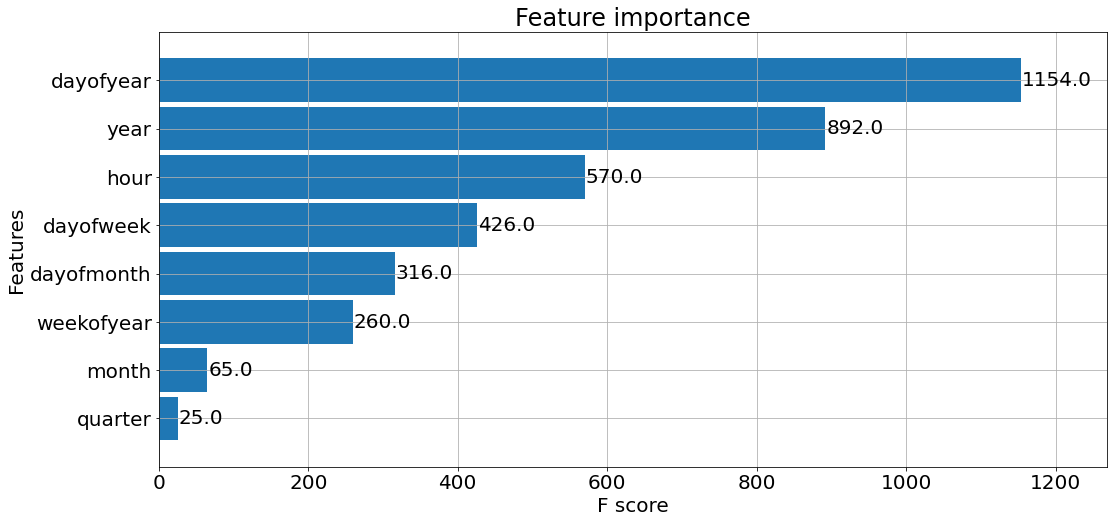

In [14]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set (in-sample)
<hr style="border:2px solid black"> </hr>

In [15]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

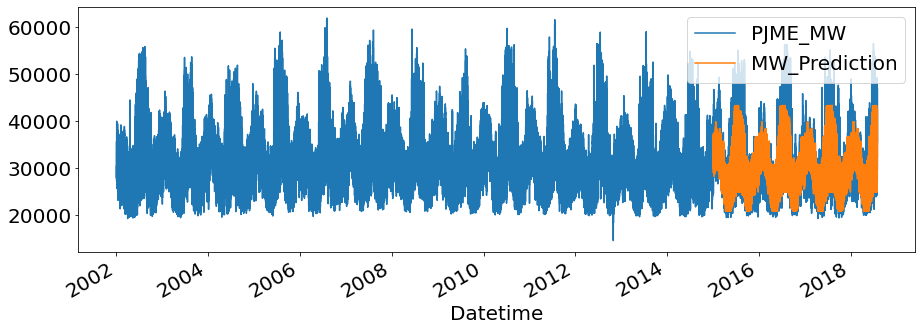

In [16]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

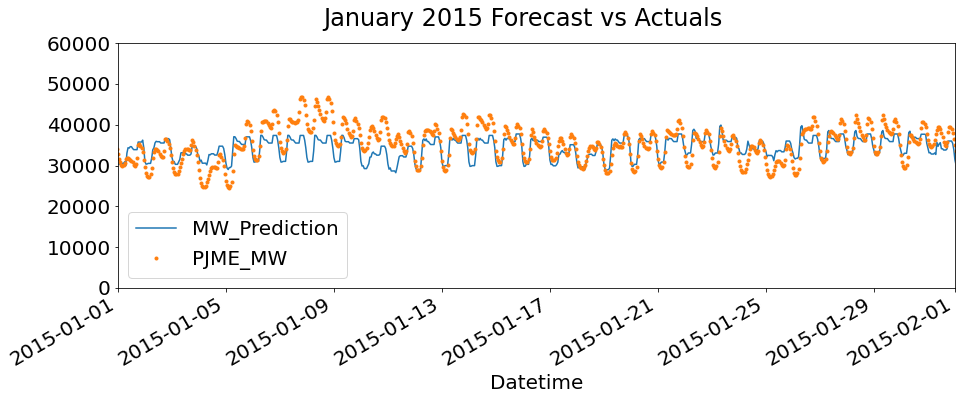

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

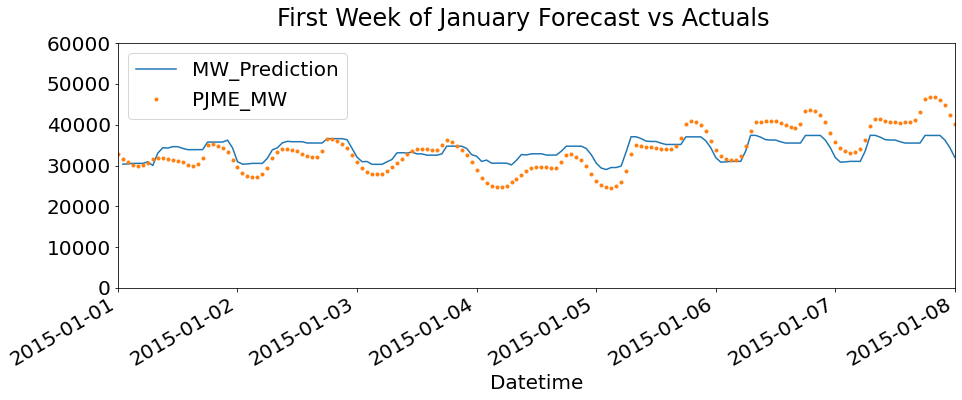

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

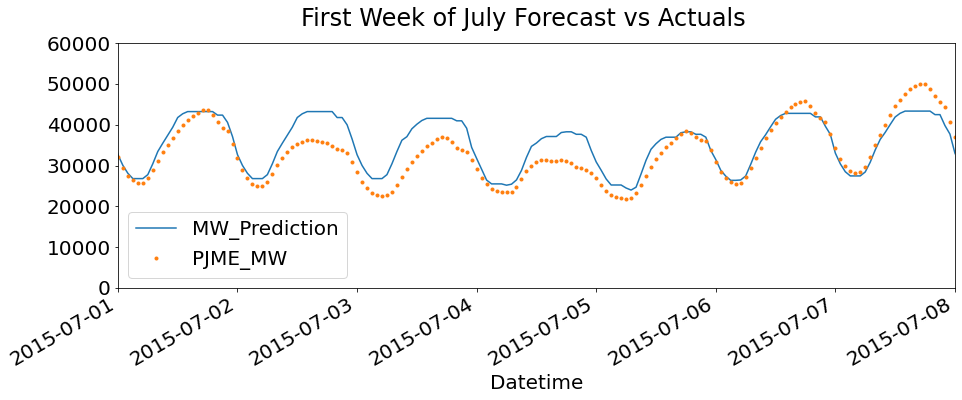

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')


# Error metrics on the test set


- You'll see how by looking at the MSE and MAE, the numbers would not say much, unless you are an expert in the field.
- I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. 
- **MAPE** isn't included in sklearn so we need to use a custom function.



In [20]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

13960913.30565261

In [21]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2757.2169004982866

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.510847348494002

# Look at Worst and Best Predicted Days


- Can the inspction of best and worst prediction give us insights of what we can do to improve the mode? 
- The first and second entry are holidays!
- It looks like our model could benefit from using an holiday indicator.



In [24]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [25]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36429.839844 -8029.882894  8029.882894
2017 2     24          26445.083333   34425.839844 -7980.756429  7980.756429
           25          24344.458333   31702.664062 -7358.206299  7358.206299
     9     4           26552.416667   33609.351562 -7056.935954  7056.935954
     2     20          27070.583333   33860.238281 -6789.655355  6789.655355
     9     1           27280.500000   33966.476562 -6685.977132  6685.977132
     2     19          24555.500000   31178.527344 -6623.027913  6623.027913
2018 2     21          27572.500000   34057.515625 -6485.015869  6485.015869
2017 3     1           27574.125000   34057.515625 -6483.390869  6483.390869
     2     23          27663.416667   34141.667969 -6478.251872  6478.251872

In [26]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31390.199219  13795.634766  13795.634766
           14          44427.333333   31185.371094  13241.961751  13241.961751
     9     10          40996.166667   27985.250000  13010.917562  13010.917562
           9           43836.958333   32078.492188  11758.466064  11758.466064
     8     12          45724.708333   34440.406250  11284.303223  11284.303223
2018 1     6           43565.750000   32572.080078  10993.670003  10993.670003
2015 2     20          44694.041667   33874.218750  10819.821045  10819.821045
2017 5     19          38032.583333   27777.609375  10254.974935  10254.974935
2015 2     16          43949.500000   33860.238281  10089.261312  10089.261312
     9     9           42266.875000   32276.361328   9990.514160   9990.514160

In [27]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2018 5     13          24001.500000   24218.675781 -217.174967  338.625000
2016 4     4           28944.125000   28569.861328  374.264323  429.709147
     9     28          27910.833333   28260.042969 -349.209961  479.797038
2015 10    3           25534.875000   25807.496094 -272.620850  485.690348
     9     22          28185.875000   28314.941406 -129.067383  496.139974
     4     20          27369.000000   27608.917969 -239.918376  503.891357
2018 5     17          28035.208333   28513.269531 -478.060872  515.793783
2016 10    2           24659.083333   25016.308594 -357.224284  515.855794
2015 9     21          27988.041667   28057.207031  -69.165365  517.167806
2017 5     13          24752.333333   24626.263672  126.069092  531.713135

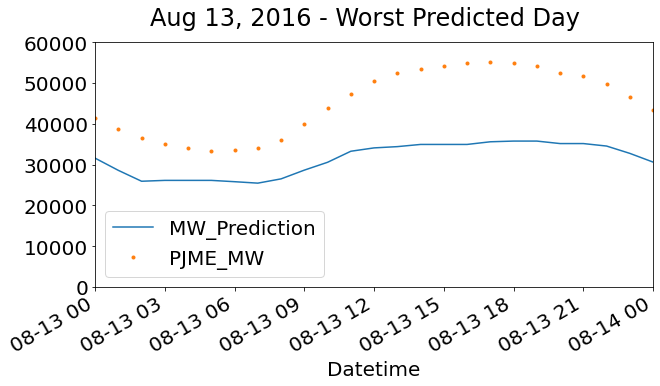

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

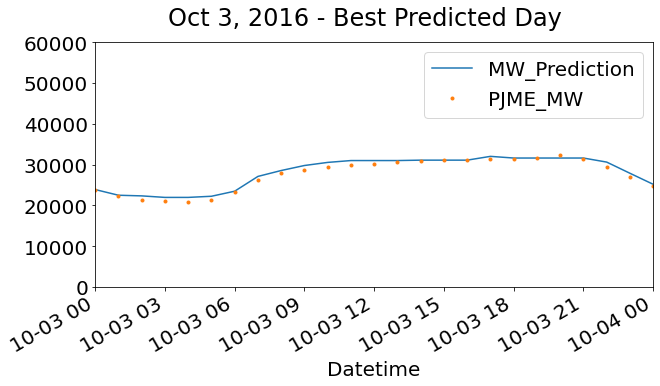

In [29]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

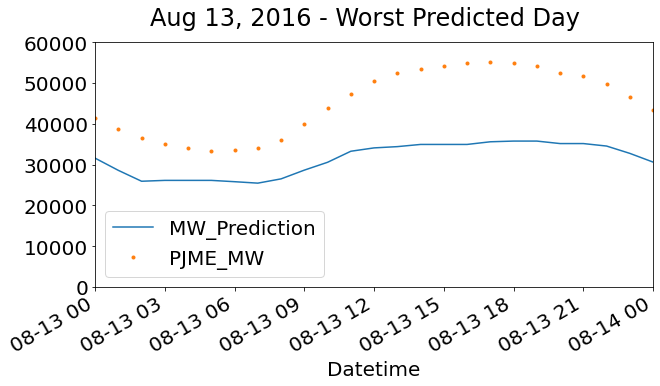

In [30]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# References
<hr style="border:2px solid black"> </hr>


- https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
- [Link to the dataset](https://www.kaggle.com/robikscube/hourly-energy-consumption/version/3?select=PJME_hourly.csv)

